Unemployment is a very real problem in virtually every country. A small unemployment percentage is normal and healthy for the economy, but there are times when it becomes problematic.
What could affect unemployment in the Netherlands? I will be using linear regression to try and predict the NL unemployment using monthly data gathered since 1996-02. The model will be far from perfect since there is not a large amount of data gathered so meticulously every month, but as Geogre E.P. Box said- all models are wrong, but some are useful. 

# IMPORTS 

In [40]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as py
import seaborn as sb
import os
import sys
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
# Add the parent directory to the Python path
sys.path.append('/Users/luiza/unemployment/unemployment_prediction/code')

# Import the module
import econometrics_modules
from econometrics_modules import pull_data  # Importing a function that pulls data from Eurostat

# Verify the module path
print(econometrics_modules.__file__)

/Users/luiza/unemployment/unemployment_prediction/code/econometrics_modules.py


/Users/luiza/unemployment/unemployment_prediction/unemployment_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
from econometrics_modules import clean_dataframe , is_year_month_format, adf_test

# IMPORTING DATASETS FROM EUROSTAT:

In [4]:
#Price index.
pull_data('prc_hicp_mmor', 'price_index.csv')

In [5]:
#Unemployment rate
pull_data('ei_lmhr_m', 'unemployment_rate.csv')

In [6]:
#economic sentiment indicator
pull_data('ei_bssi_m_r2', 'sentiment_indicator.csv')

In [7]:
#retail sale
pull_data('ei_bsrt_m_r2', 'retail_sale.csv')

In [8]:
#Industrial Production Index (IPI)
pull_data('sts_inpr_m', 'industrial_production.csv')

In [9]:
#employment expectations over the next 3 months
pull_data('ei_bsrt_m_r2', 'empl_exp.csv')

# Why i chose these variables

My goal is to accurately predict monthly unemployment. The price index, according to economic theory, reflects inflation. Inflation and unemployment are closely related. Low unemployment correlates with high inflation, and high unemployment with low inflation, BUT the relationship is complex and nuanced apart from that straightforward correlation.

Past unemployment rate affects present unemployment rate.

The economic sentiment indicator is, I think, an important variable. It is an index that tells us about how optimistic emplyers are about the economy. If they are optimistic, they will increase vacancies, if not, they will cut costs and decrease vacancies.

The retail sale indicator works the same way as the economic sentiment one, but in retail.

IPI- lots of industrial production might mean that the economy is in a good state and there will be less unemployment.

Employment expectations are also closely related to how employers feel about the future when they observe the economic state of the country.

Notice that I missed out on a lot of potentially significant data like number of immigrants, women in the job market, education levels etc just because there is no monthly data available on these topics!.

# DATA FORMATTING AND CLEANING

In [10]:
#Price Index formatting
price_index = pd.read_csv('data/price_index.csv')
clean_dataframe(price_index, 5 ,'price_index')

In [11]:
#Unemployment rate - formatting
unemployment_rate = pd.read_csv('data/unemployment_rate.csv')
clean_dataframe(unemployment_rate, 8, 'unemployment_rate')

In [12]:
#Economic sentiment indicator - formatting
sentiment_indicator = pd.read_csv('data/sentiment_indicator.csv')
clean_dataframe(sentiment_indicator, 0, 'sentiment_indicator')

In [13]:
#Retail sale - formatting
retail_sale = pd.read_csv('data/retail_sale.csv')
clean_dataframe(retail_sale, 2, 'retail_sale')

In [14]:
#Employment expectations over the next 3 months - formatting
empl_exp = pd.read_csv('data/empl_exp.csv')
clean_dataframe(empl_exp, 6, 'empl_exp')

In [15]:
#IPI formatting
industrial_production = pd.read_csv('data/industrial_production.csv')
clean_dataframe(industrial_production, 17, 'industrial_production')

# CREATING THE DATASET FOR THE LEAST SQUARES MODEL

In [16]:
#Downloading the datasets updated with clean_dataframe module
empl_exp = pd.read_csv('data/empl_exp.csv')
industrial_production = pd.read_csv('data/industrial_production.csv')
price_index = pd.read_csv('data/price_index.csv')
retail_sale = pd.read_csv('data/retail_sale.csv')
sentiment_indicator = pd.read_csv('data/sentiment_indicator.csv')
unemployment_rate = pd.read_csv('data/unemployment_rate.csv')

In [17]:
dataset = pd.concat([empl_exp, industrial_production, price_index, retail_sale, sentiment_indicator, unemployment_rate], axis=0)

In [18]:
dataset

,2000-01-01,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01,2000-09-01,2000-10-01,...,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01
0,14.7,12.7,9.7,14.7,11.7,11.7,9.7,13.7,9.7,9.7,...,1.8,4.6,3.4,-1.6,-0.3,-1.2,0.8,-0.2,0.0,-5.1
0,87.4,84.7,100.7,90.6,99.5,89.7,88.7,87.6,91.1,97.1,...,99.4,105.5,101.5,101.7,102.2,100.9,92.5,99.9,105.1,104.3
0,-0.3,0.6,1.1,0.4,0.3,0.0,-0.3,0.4,0.9,0.4,...,0.9,0.6,1.1,0.3,0.2,1.3,0.4,-0.9,0.6,-1.0
0,27.8,26.5,28.5,29.5,28.8,27.5,28.5,29.5,27.5,26.1,...,5.7,-1.6,2.7,-2.4,-6.1,-1.8,0.0,-2.4,0.3,6.1
0,10.5,15.5,19.5,22.5,19.0,21.5,25.0,24.2,24.2,16.7,...,6.5,7.4,9.0,6.8,10.7,11.7,11.2,14.7,12.1,12.0
0,4.1,4.2,4.2,3.9,3.8,3.7,3.3,3.3,3.5,3.5,...,3.9,3.7,3.6,3.5,3.7,3.5,3.7,3.9,3.7,3.5


In [19]:
dataset.index = ['EmplExp', 'InProdIndx' , 'PriceIndex', 'RetailIndic', 'EconSntIdic', 'UnemplRate'] 

In [20]:
dataset = dataset.transpose()

In [21]:
#Define the dataset file path
file_path = os.path.join('data', 'dataset.csv')

# Save the dataset to the CSV file
dataset.to_csv(file_path, index=False)

In [22]:
dataset

,EmplExp,InProdIndx,PriceIndex,RetailIndic,EconSntIdic,UnemplRate
2000-01-01,14.7,87.4,-0.3,27.8,10.5,4.1
2000-02-01,12.7,84.7,0.6,26.5,15.5,4.2
2000-03-01,9.7,100.7,1.1,28.5,19.5,4.2
2000-04-01,14.7,90.6,0.4,29.5,22.5,3.9
2000-05-01,11.7,99.5,0.3,28.8,19.0,3.8
...,...,...,...,...,...,...
2024-07-01,-1.2,100.9,1.3,-1.8,11.7,3.5
2024-08-01,0.8,92.5,0.4,0.0,11.2,3.7
2024-09-01,-0.2,99.9,-0.9,-2.4,14.7,3.9
2024-10-01,0.0,105.1,0.6,0.3,12.1,3.7


# EXPLORATORY DATA ANALYSIS

In [23]:
print(dataset.head())

            EmplExp  InProdIndx  PriceIndex  RetailIndic  EconSntIdic  \
2000-01-01     14.7        87.4        -0.3         27.8         10.5   
2000-02-01     12.7        84.7         0.6         26.5         15.5   
2000-03-01      9.7       100.7         1.1         28.5         19.5   
2000-04-01     14.7        90.6         0.4         29.5         22.5   
2000-05-01     11.7        99.5         0.3         28.8         19.0   

            UnemplRate  
2000-01-01         4.1  
2000-02-01         4.2  
2000-03-01         4.2  
2000-04-01         3.9  
2000-05-01         3.8  


In [24]:
print(dataset.info())
print(dataset.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 2000-01-01 to 2024-11-01
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EmplExp      299 non-null    float64
 1   InProdIndx   299 non-null    float64
 2   PriceIndex   299 non-null    float64
 3   RetailIndic  299 non-null    float64
 4   EconSntIdic  299 non-null    float64
 5   UnemplRate   299 non-null    float64
dtypes: float64(6)
memory usage: 24.5+ KB
None
         EmplExp  InProdIndx  PriceIndex  RetailIndic  EconSntIdic  UnemplRate
count  299.00000  299.000000  299.000000   299.000000   299.000000  299.000000
mean     2.33612   99.530769    0.201338     5.424749     0.066221    5.486288
std      8.18824    6.459460    0.749585    10.339342    20.858958    1.559786
min    -17.80000   81.900000   -3.900000   -19.500000   -53.400000    2.700000
25%     -2.30000   95.750000   -0.300000    -2.000000   -17.250000    4.150000
50%      3.10000   99.600000

In [25]:
print(dataset.isnull().sum())

EmplExp        0
InProdIndx     0
PriceIndex     0
RetailIndic    0
EconSntIdic    0
UnemplRate     0
dtype: int64


yay!

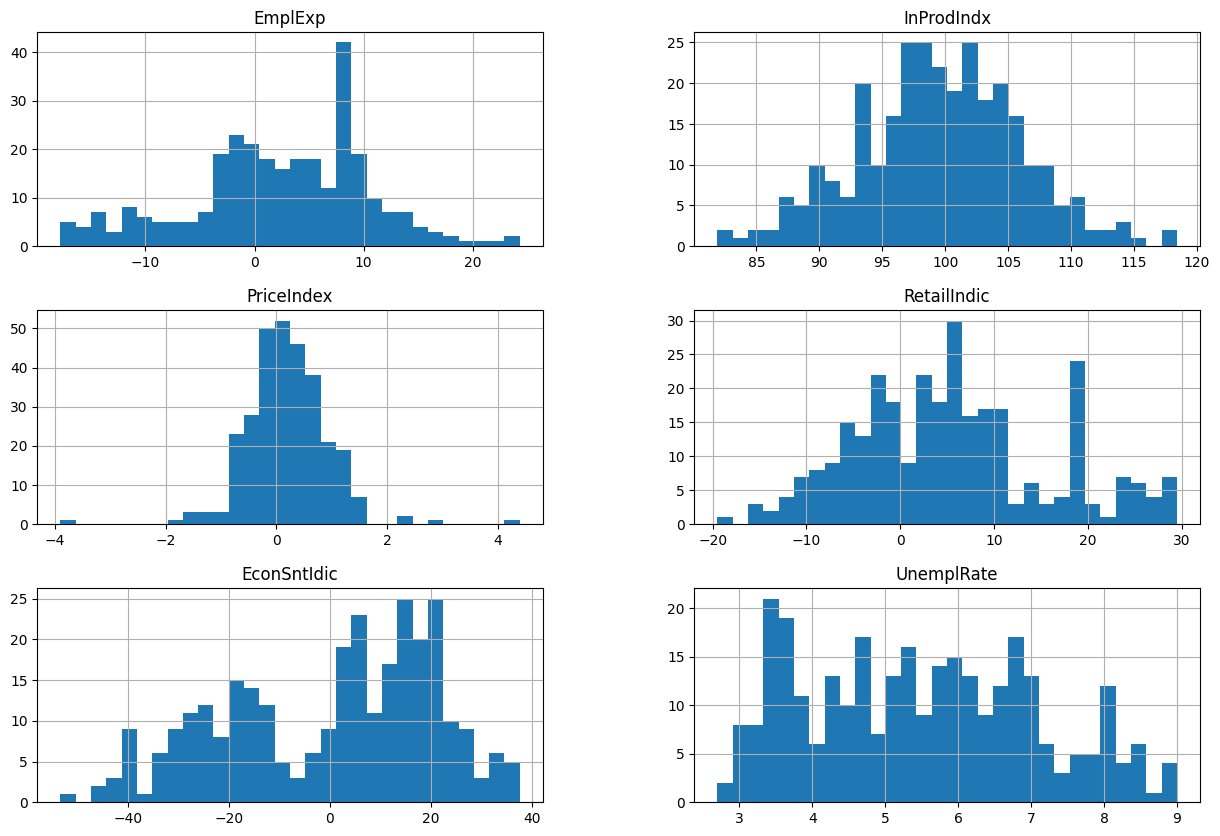

In [26]:
dataset.hist(bins=30, figsize=(15, 10))
plt.pyplot.show()


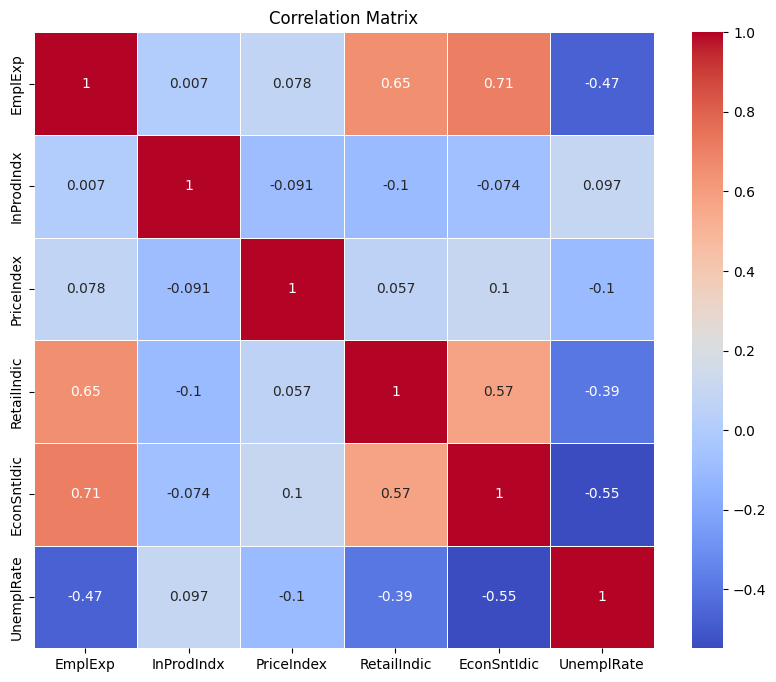

In [27]:
# Correlation matrix
plt.pyplot.figure(figsize=(10, 8))
sb.heatmap(dataset.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.pyplot.title('Correlation Matrix')
plt.pyplot.show()

Strong correlation between expected employment and economic sentiment, as well as retail indicator. Strong negative correlation between unemployment rate and economic sentiment, which was predictable. 

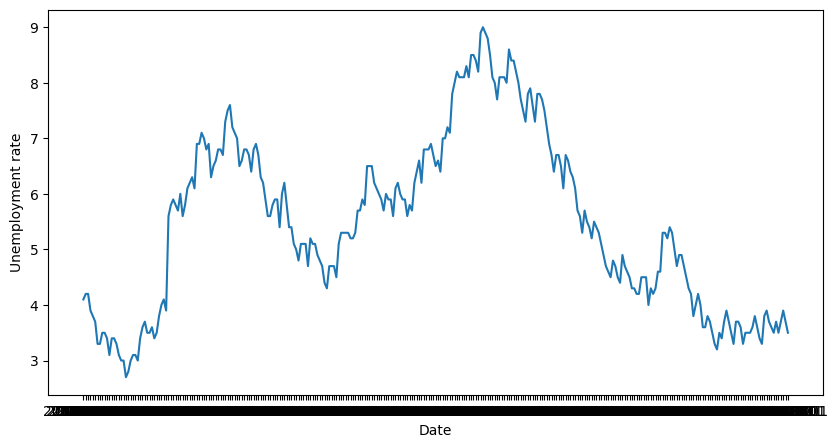

In [28]:
# Plot the time series data with seaborn
plt.pyplot.figure(figsize=(10, 5))
sb.lineplot(x=dataset.index, y=dataset['UnemplRate'])
plt.pyplot.xlabel('Date')
plt.pyplot.ylabel('Unemployment rate')
plt.pyplot.show()


I'm curious about the correlation between unemployment and past unemployment.

<Figure size 1200x600 with 0 Axes>

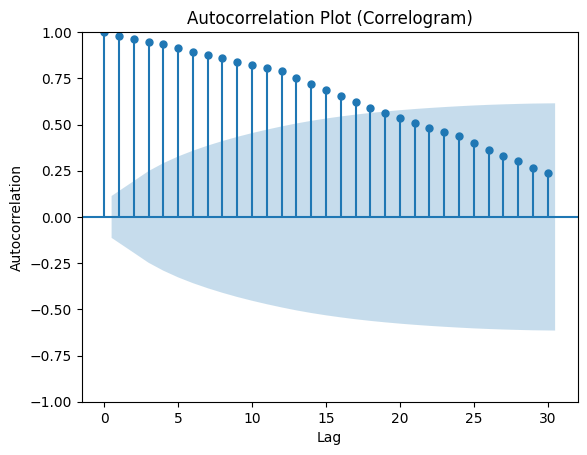

In [29]:
# Plot the autocorrelation function (ACF)
plt.pyplot.figure(figsize=(12, 6))
plot_acf(dataset['UnemplRate'], lags=30)
plt.pyplot.title('Autocorrelation Plot (Correlogram)')
plt.pyplot.xlabel('Lag')
plt.pyplot.ylabel('Autocorrelation')
plt.pyplot.show()

In [30]:
print(dataset)

            EmplExp  InProdIndx  PriceIndex  RetailIndic  EconSntIdic  \
2000-01-01     14.7        87.4        -0.3         27.8         10.5   
2000-02-01     12.7        84.7         0.6         26.5         15.5   
2000-03-01      9.7       100.7         1.1         28.5         19.5   
2000-04-01     14.7        90.6         0.4         29.5         22.5   
2000-05-01     11.7        99.5         0.3         28.8         19.0   
...             ...         ...         ...          ...          ...   
2024-07-01     -1.2       100.9         1.3         -1.8         11.7   
2024-08-01      0.8        92.5         0.4          0.0         11.2   
2024-09-01     -0.2        99.9        -0.9         -2.4         14.7   
2024-10-01      0.0       105.1         0.6          0.3         12.1   
2024-11-01     -5.1       104.3        -1.0          6.1         12.0   

            UnemplRate  
2000-01-01         4.1  
2000-02-01         4.2  
2000-03-01         4.2  
2000-04-01         3.9 

# REGRESSION

Based on the visualisation of the Price Index time series above, I think some of the time series I chose for the analysis might not be stationary, which is problematic and requires replacing the data with first differences so that it's stationary.  Let's check it with the ADF test. 


In [31]:
# Check for stationarity using ADF test

adf_test(dataset['UnemplRate'], name='Unemployment Rate')
adf_test(dataset['EmplExp'], name='Employment expectations')
adf_test(dataset['InProdIndx'], name='Industrial Production Index')
adf_test(dataset['PriceIndex'], name= 'Price Index')
adf_test(dataset['RetailIndic'], name= 'Retail Indicator')
adf_test(dataset['EconSntIdic'], name= 'Economic Sentiment')


ADF Test on "Unemployment Rate"
-----------------------------------------------
Test Statistic : -2.5998095593784196
p-value : 0.09303663403062051
#Lags Used : 15
Number of Observations Used : 283
Critical Value (1%) : -3.453670163592738
Critical Value (5%) : -2.8718077069772248
Critical Value (10%) : -2.5722411158835796
Result: Series is Non-Stationary
ADF Test on "Employment expectations"
-----------------------------------------------
Test Statistic : -3.1948759463268788
p-value : 0.02028320203110825
#Lags Used : 13
Number of Observations Used : 285
Critical Value (1%) : -3.4535050041524245
Critical Value (5%) : -2.8717352599720294
Critical Value (10%) : -2.5722024776854417
Result: Series is Stationary
ADF Test on "Industrial Production Index"
-----------------------------------------------
Test Statistic : -3.0133959827145786
p-value : 0.033662181250046955
#Lags Used : 14
Number of Observations Used : 284
Critical Value (1%) : -3.4535872903895797
Critical Value (5%) : -2.8717713552

So we do have a problem with unemployment rate, price index and economic sentiment. Let's test the first differences.


In [32]:
# Difference the data to make it stationary
cols_to_diff= ['UnemplRate', 'PriceIndex', 'EconSntIdic']
dataset_diff = dataset[cols_to_diff].diff().dropna()



In [33]:
# Re-check stationarity of differenced data
adf_test(dataset_diff['UnemplRate'], name='UnemplRateDiff')
adf_test(dataset_diff['PriceIndex'], name='PriceIndexDiff')
adf_test(dataset_diff['EconSntIdic'], name='ESIDiff')

ADF Test on "UnemplRateDiff"
-----------------------------------------------
Test Statistic : -3.0384978312089
p-value : 0.03145226350632695
#Lags Used : 14
Number of Observations Used : 283
Critical Value (1%) : -3.453670163592738
Critical Value (5%) : -2.8718077069772248
Critical Value (10%) : -2.5722411158835796
Result: Series is Stationary
ADF Test on "PriceIndexDiff"
-----------------------------------------------
Test Statistic : -14.521698507097538
p-value : 5.510902982361861e-27
#Lags Used : 10
Number of Observations Used : 287
Critical Value (1%) : -3.453342167806272
Critical Value (5%) : -2.871663828287282
Critical Value (10%) : -2.572164381381345
Result: Series is Stationary
ADF Test on "ESIDiff"
-----------------------------------------------
Test Statistic : -19.029589914179905
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 297
Critical Value (1%) : -3.4525611751768914
Critical Value (5%) : -2.87132117782556
Critical Value (10%) : -2.5719816428028888
Result: Se

In [34]:
dataset_diff['UnemplRate_lag1'] = dataset_diff['UnemplRate'].shift(1) #adding the lagged unemployment rate
dataset_diff_x = dataset_diff[['PriceIndex', 'EconSntIdic', 'UnemplRate_lag1']]  
dataset_x = dataset[['EmplExp', 'InProdIndx', 'RetailIndic']]

# Concatenate the DataFrames
X = pd.concat([dataset_diff_x, dataset_x], axis=1)
X = X.replace([np.inf, -np.inf], np.nan).dropna()



# Define the dependent variable
y = dataset_diff.loc[X.index, 'UnemplRate'] #the loc is necessary because the index of X is different from the index of y bc of the addeg lag

# Fit the linear regression model
model = sm.OLS(y, X).fit()

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             UnemplRate   R-squared (uncentered):                   0.059
Model:                            OLS   Adj. R-squared (uncentered):              0.040
Method:                 Least Squares   F-statistic:                              3.057
Date:                Fri, 04 Apr 2025   Prob (F-statistic):                     0.00646
Time:                        16:03:41   Log-Likelihood:                         -23.878
No. Observations:                 297   AIC:                                      59.76
Df Residuals:                     291   BIC:                                      81.92
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
PriceIndex          0.0200      0.016      1.259      0.209      -0.011       0.051
EconSntIdic         0.0002      0.003      0.052      0.959      -0.007       0.007
UnemplRate_lag1    -0.1024      0.059     -1.748      0.082      -0.218       0.013
EmplExp            -0.0075      0.002     -2.990      0.003      -0.012      -0.003
InProdIndx          0.0001      0.000      0.740      0.460      -0.000       0.000
RetailIndic     -7.837e-05      0.002     -0.040      0.968      -0.004       0.004
==============================================================================
Omnibus:                       87.924   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.763
Skew:                           1.202   Prob(JB):                     1.85e-76
Kurtosis:                       7.733   Cond. No.                         382.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Unfortunaly, the model is not significant when corrected for the stationarity. There is a lot of room for further improvement in the model.

In [36]:
# Make predictions
predictions = model.predict(X)

# Add predictions to the dataset for comparison
dataset_diff['Predicted_UnemplRate'] = predictions

# Display the actual vs predicted values
print(dataset_diff[['UnemplRate', 'Predicted_UnemplRate']].head())

            UnemplRate  Predicted_UnemplRate
2000-02-01         0.1                   NaN
2000-03-01         0.0             -0.061209
2000-04-01        -0.3             -0.113837
2000-05-01        -0.1             -0.048700
2000-06-01        -0.1             -0.073257


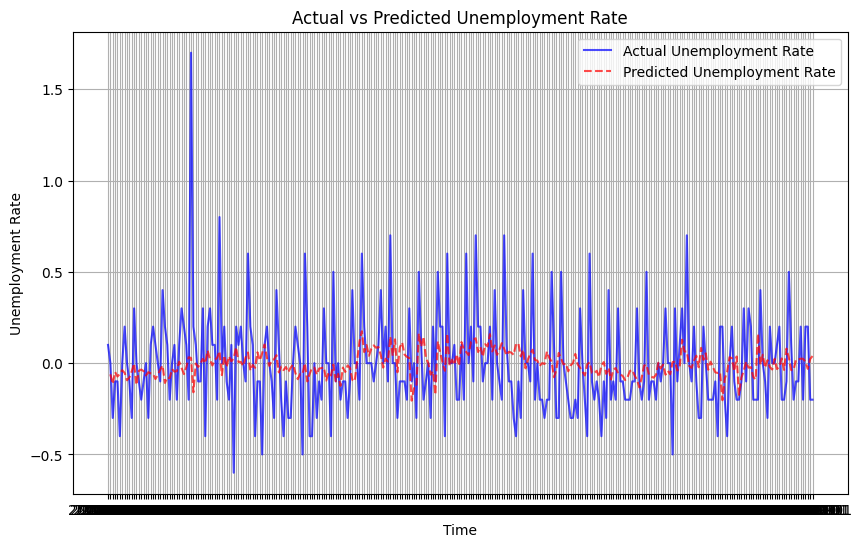

In [42]:
# Plot the actual vs predicted values
py.figure(figsize=(10, 6))
py.plot(dataset_diff['UnemplRate'], label='Actual Unemployment Rate', color='blue', alpha=0.7)
py.plot(dataset_diff['Predicted_UnemplRate'], label='Predicted Unemployment Rate', color='red', linestyle='--', alpha=0.7)

# Add labels, title, and legend
py.title('Actual vs Predicted Unemployment Rate')
py.xlabel('Time')
py.ylabel('Unemployment Rate')
py.legend()
py.grid(True)

# Show the plot
py.show()

Since the model is not significant, it is currently not the best tool for predicting unemployment. 